In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/hap_sad_neu.zip'

-rw------- 1 root root 389872894 Nov  5 05:29 '/content/drive/My Drive/Colab Notebooks/datasets/hap_sad_neu.zip'


In [ ]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/datasets/hap_sad_neu.zip

Archive:  /content/drive/MyDrive/Colab Notebooks/datasets/hap_sad_neu.zip
   creating: train/happy/
  inflating: train/happy/01a6c69e76d729863380b8391d780e53070cf8629ad9ffd5d06826551271fe74_│▓_30_▒т╗▌_░°░°╜├╝│_┴╛▒│_└╟╖с╜├╝│_20201207110057-001-005.jpg  
  inflating: train/happy/01a6c69e76d729863380b8391d780e53070cf8629ad9ffd5d06826551271fe74_│▓_30_▒т╗▌_╡╡╜╔ ╚п░ц_20201207110139-008-010.jpg  
  inflating: train/happy/01a6c69e76d729863380b8391d780e53070cf8629ad9ffd5d06826551271fe74_│▓_30_▒т╗▌_╡╡╜╔ ╚п░ц_20201207110139-008-013.jpg  
  inflating: train/happy/01a6c69e76d729863380b8391d780e53070cf8629ad9ffd5d06826551271fe74_│▓_30_▒т╗▌_╣о╚н└ч ╣╫ └п└√┴Ў_20201207110149-009-028.jpg  
  inflating: train/happy/01a6c69e76d729863380b8391d780e53070cf8629ad9ffd5d06826551271fe74_│▓_30_▒т╗▌_╜║╞ў├ў ░№╢ў ╣╫ ╖╣└·╜├╝│_20201207110113-004-005.jpg  
  inflating: train/happy/01a6c69e76d729863380b8391d780e53070cf8629ad9ffd5d06826551271fe74_│▓_30_▒т╗▌_╜║╞ў├ў ░№╢ў ╣╫ ╖╣└·╜├╝│_20201207110113-004-010.jpg  
  inflating:

In [ ]:
!ls -l

total 16
drwx------ 5 root root 4096 Nov  5 06:24 drive
drwxr-xr-x 1 root root 4096 Nov  1 13:35 sample_data
drwxr-xr-x 5 root root 4096 Nov  5 06:24 train
drwxr-xr-x 5 root root 4096 Nov  5 06:24 validation


In [ ]:
train_dir = 'train'
valid_dir = 'validation'

# build model

## VGG16

### 데이터 증식을 사용하지 않는 빠른 특성 추출

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,200,3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 100, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 100, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 100, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 50, 128)       0     

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size=20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 6, 512))
    labels = np.zeros(shape=(sample_count, 3))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,200),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size]=features_batch
        labels[i * batch_size : (i + 1) * batch_size]=labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 3000)
validation_features, validation_labels = extract_features(valid_dir, 1500)

Found 3000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [ ]:
train_features = np.reshape(train_features, (3000, 4 * 6 * 512))
validation_features = np.reshape(validation_features, (1500, 4 * 6 * 512))

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 6 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=200,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/200
150/150 [==============================] - 2s 9ms/step - loss: 0.9801 - acc: 0.5373 - val_loss: 0.7718 - val_acc: 0.6913
Epoch 2/200
150/150 [==============================] - 1s 7ms/step - loss: 0.7257 - acc: 0.6967 - val_loss: 0.6493 - val_acc: 0.7400
Epoch 3/200
150/150 [==============================] - 1s 8ms/step - loss: 0.6414 - acc: 0.7403 - val_loss: 0.6067 - val_acc: 0.7487
Epoch 4/200
150/150 [==============================] - 1s 8ms/step - loss: 0.5819 - acc: 0.7680 - val_loss: 0.5656 - val_acc: 0.7647
Epoch 5/200
150/150 [==============================] - 1s 7ms/step - loss: 0.5191 - acc: 0.7927 - val_loss: 0.5355 - val_acc: 0.7787
Epoch 6/200
150/150 [==============================] - 1s 8ms/step - loss: 0.4942 - acc: 0.8087 - val_loss: 0.5208 - val_acc: 0.7833
Epoch 7/200
150/150 [==============================] - 1s 7ms/step - loss: 0.4505 - acc: 0.8197 - val_loss: 0.5057 - val_acc: 0.7907
Epoch 8/200
150/150 [==============================] - 1s 8ms/step - 

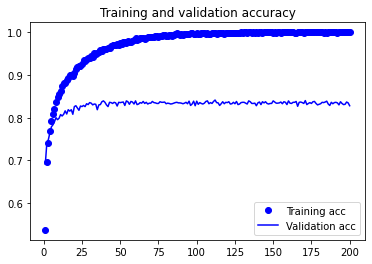

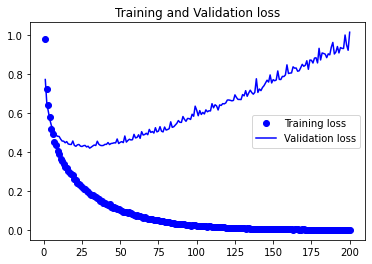

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/models/hap_sad_neu_VGG16_noImaug.h5')

### val_loss 낮은 모델

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,200,3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 100, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 100, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 100, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 50, 128)       0     

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size=20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 6, 512))
    labels = np.zeros(shape=(sample_count, 3))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,200),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size]=features_batch
        labels[i * batch_size : (i + 1) * batch_size]=labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 3000)
validation_features, validation_labels = extract_features(valid_dir, 1500)

Found 3000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [ ]:
train_features = np.reshape(train_features, (3000, 4 * 6 * 512))
validation_features = np.reshape(validation_features, (1500, 4 * 6 * 512))

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 6 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
150/150 [==============================] - 2s 10ms/step - loss: 0.9636 - acc: 0.5390 - val_loss: 0.7293 - val_acc: 0.7000
Epoch 2/30
150/150 [==============================] - 1s 7ms/step - loss: 0.7109 - acc: 0.6873 - val_loss: 0.6476 - val_acc: 0.7313
Epoch 3/30
150/150 [==============================] - 1s 8ms/step - loss: 0.5955 - acc: 0.7603 - val_loss: 0.5991 - val_acc: 0.7493
Epoch 4/30
150/150 [==============================] - 1s 7ms/step - loss: 0.5395 - acc: 0.7840 - val_loss: 0.5531 - val_acc: 0.7647
Epoch 5/30
150/150 [==============================] - 1s 7ms/step - loss: 0.4898 - acc: 0.8023 - val_loss: 0.5259 - val_acc: 0.7820
Epoch 6/30
150/150 [==============================] - 1s 7ms/step - loss: 0.4668 - acc: 0.8207 - val_loss: 0.5131 - val_acc: 0.7827
Epoch 7/30
150/150 [==============================] - 1s 7ms/step - loss: 0.4308 - acc: 0.8367 - val_loss: 0.4911 - val_acc: 0.7880
Epoch 8/30
150/150 [==============================] - 1s 8ms/step - loss: 0

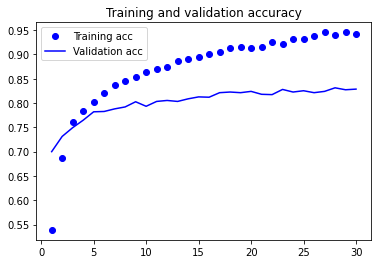

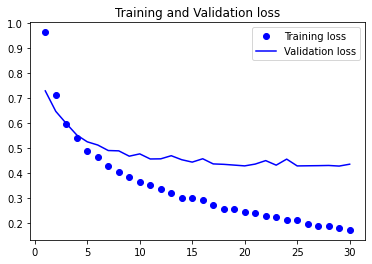

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/models/hap_sad_neu_VGG16_noImaug2.h5')

# test

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/models/hap_sad_neu_VGG16_noImaug2.h5')

In [ ]:
hap_path = '/content/drive/My Drive/Colab Notebooks/datasets/happy_test.jpg'
neu_path = '/content/drive/My Drive/Colab Notebooks/datasets/neu_test.jpg'
sad_path = '/content/drive/My Drive/Colab Notebooks/datasets/sad_test.jpg'
sad_neu_path = '/content/drive/My Drive/Colab Notebooks/datasets/sad_neu_test.jpg'
emb_path = '/content/drive/My Drive/Colab Notebooks/datasets/emb_test.jpg'

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def mk_img_tensor(img_path):
    img = image.load_img(img_path, target_size=(150,200))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    print(img_tensor.shape)
    return img_tensor

In [ ]:
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,200,3))

def percentage(test):
    plt.imshow(test[0])
    plt.show()
    test=conv_base.predict(test)
    test=np.reshape(test, (1, 4 * 6 * 512))
    print('happy:',  model.predict(test)[0][0])
    print('neutrality:',  model.predict(test)[0][1])
    print('sad:',  model.predict(test)[0][2])

In [ ]:
hap_test = mk_img_tensor(hap_path)
neu_test = mk_img_tensor(neu_path)
sad_test = mk_img_tensor(sad_path)
sad_neu_test = mk_img_tensor(sad_neu_path)
emb_test = mk_img_tensor(emb_path)

(1, 150, 200, 3)
(1, 150, 200, 3)
(1, 150, 200, 3)
(1, 150, 200, 3)
(1, 150, 200, 3)


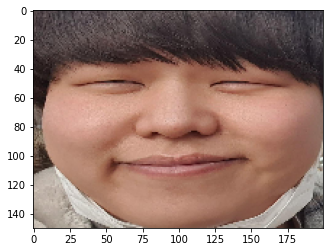

happy: 0.83671373
neutrality: 0.022039708
sad: 0.14124653


In [ ]:
percentage(hap_test)

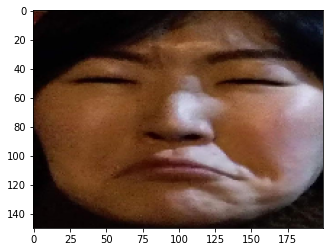

happy: 0.0033525194
neutrality: 0.017192002
sad: 0.9794555


In [ ]:
percentage(sad_test)

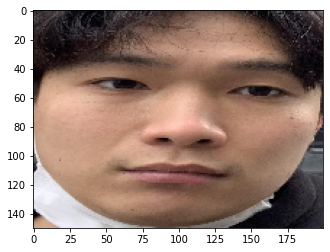

happy: 0.002436423
neutrality: 0.98359364
sad: 0.013969889


In [ ]:
percentage(neu_test)

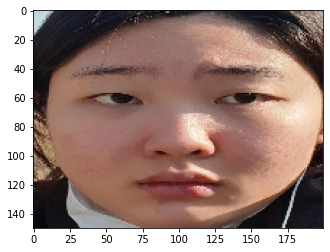

happy: 0.0022257003
neutrality: 0.96227914
sad: 0.035495147


In [ ]:
percentage(sad_neu_test)

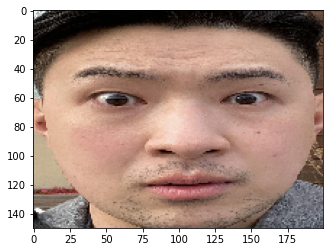

happy: 8.539901e-05
neutrality: 0.99777704
sad: 0.0021376046


In [ ]:
percentage(emb_test)